## The stochastic SIkR model

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### Simulation of a single stochastic trajectory

In [3]:
M = 1                  # the SIR model has no age structure
Ni = 1000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.2            # infection rate 
gI   = 0.05            # recovery rate of asymptomatic infectives 
k   = 5           # recovery rate of symptomatic infectives 
fsa   = 1              # the self-isolation parameter 


I0 = np.zeros(k,dtype=int)
I0[0] = 5                     # initially, we have 5 infected in "stage 0"
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(np.sum(I0)+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 100;  Nt=Tf+1; 

# instantiate model
parameters = {'alpha':0., 'beta':beta, 'gI':gI, 'k':k,'fsa':fsa}
model = pyross.stochastic.SIkR(parameters, M, Ni)

# simulate model 
data = model.simulate(S0, I0, contactMatrix, Tf, Nt)

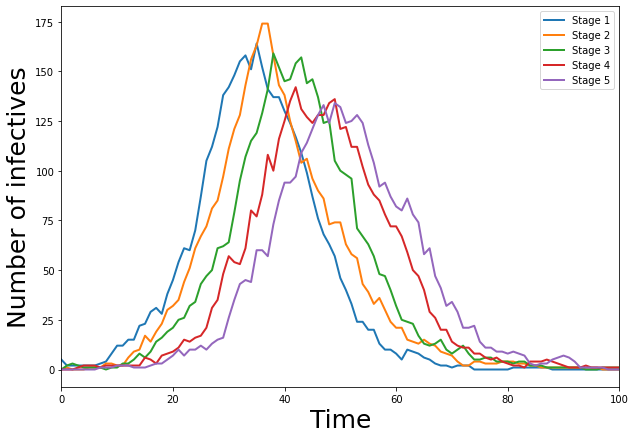

In [4]:
# Plot of the k stages
fig, ax = plt.subplots(1,1,figsize=(10,7))

X = data['X'].T
t_arr = data['t']
for i,e in enumerate(X):
    if i == 0:
        continue
    ax.plot(t_arr,e,label='Stage {0}'.format(i),lw=2)
ax.legend()
ax.set_xlim(np.min(t_arr),np.max(t_arr))
ax.set_xlabel('Time',fontsize=25)
ax.set_ylabel(r'Number of infectives',fontsize=25)
plt.show(fig)
plt.close(fig)

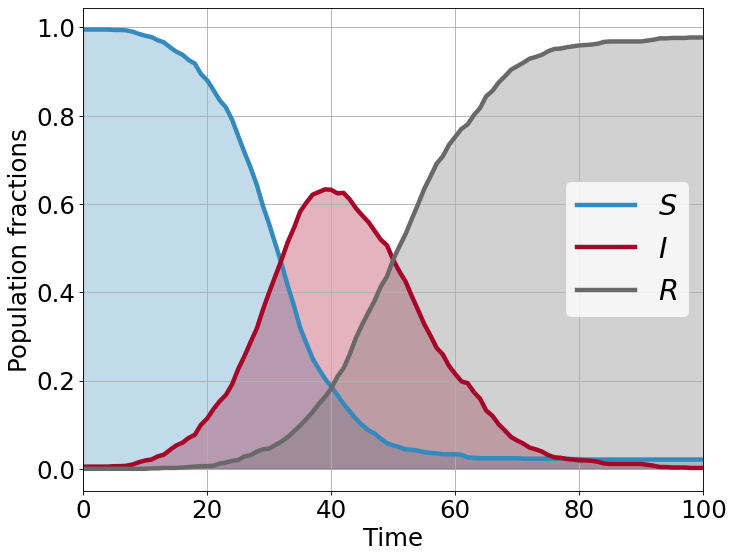

In [5]:
# Plot of the sum of all stages, i.e. the total number of infectives

X = data['X'].T

I = np.sum( X[1:,:], axis = 0)
S  = X[0].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I/N, '-', color='#A60628', label='$I$', lw=4)

R=N-S-I; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid()
plt.xlabel('Time')
plt.ylabel('Population fractions')
plt.autoscale(enable=True, axis='x', tight=True)

Note that, since here sample trajectories for the stochastic model are generated, a slightly different plot will result every time the two cells above are run. 


### Averaging over several simulations

If the simulation is run many times, mean and standard deviation of the resulting trajectories can be calculated.

In [6]:
# run 100 simulations, calculate mean and standard deviation

N_runs = 100
trajectories_s = np.zeros([N_runs,Nt,k+1],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S0, I0, contactMatrix, Tf, Nt) 
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']

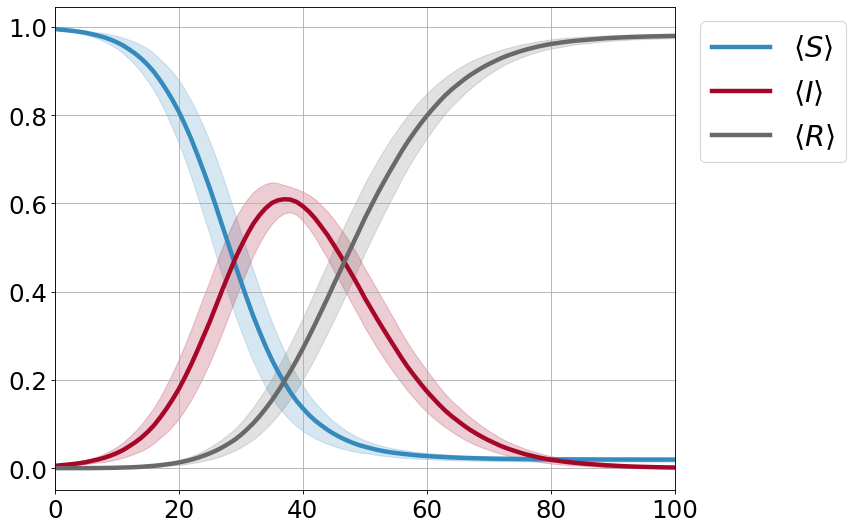

In [7]:
# plot means and standard deviations

I = np.sum( trajectories_s[:,:,1:], axis = -1)
mean_s = np.mean(trajectories_s,axis=0)
std_s = np.std(trajectories_s,axis=0)
S_s  = mean_s[:,0].flatten()
I_s = np.mean(I,axis=0).flatten()
dS_s = std_s[:,0].flatten()
dI_s =  np.std(I,axis=0).flatten()
# for the recovered, we still need to calculate mean and variance
R_s_trajectories = N - np.sum( trajectories_s, axis =-1) 
R_s = np.mean(R_s_trajectories,axis=0)
dR_s = np.std(R_s_trajectories,axis=0)


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# stochastic
plt.fill_between(t_s,(S_s - dS_s)/N,(S_s + dS_s)/N,color="#348ABD", alpha=0.2)
plt.plot(t_s, S_s/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_s,(I_s - dI_s)/N,(I_s + dI_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, I_s/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)
plt.fill_between(t_s,(R_s - dR_s)/N,(R_s + dR_s)/N,color="dimgrey", alpha=0.2)
plt.plot(t_s, R_s/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)


plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

While the solid lines denote the instantaneous means, the colored shaded regions denote the standard deviation of the samples from the instantaneous mean.

## Distributions for time-of-infection

By repeatedly simulating a single infective person, we can sample the time it takes until an infective recovers.

The total time until recovery $\tau$ is the sum of the times to get through all stages $i$, i.e.

\begin{equation}
    \tau = \sum_{i=1}^{k} \tau_i,
\end{equation}

where $\tau_i$ is the time spent in stage $i$.

Since the $\tau_i$ are all exponentially distributed, with rate parameter $\lambda = k \gamma_I$, the sum is a Gamma distribution with shape parameter $k$ and scale parameter $1/(k\gamma_I)$.

### $k=1$:

For $k=1$, i.e. a single infective stage, we expect an exponential waiting time until recovery.

In [8]:
beta  = 0.2            # infection rate 
gI   = 0.05            # recovery rate of asymptomatic infectives 
k   = 1           # number of stages

I0 = np.zeros(k,dtype=int)
I0[0] = 1                     # initially, we have 5 infected in "stage 0"
S0  = np.array([0])
Ni = np.array([1],dtype=float)

# instantiate model
parameters = {'alpha':0., 'beta':beta, 'gI':gI, 'k':k,'fsa':fsa}
model = pyross.stochastic.SIkR(parameters, M, Ni)

N_runs = 10000
waiting_times = np.zeros(N_runs,dtype=float)
for i in range(N_runs):
    data = model.simulate(S0, I0, contactMatrix, Tf, -1)
    waiting_times[i] = data['t'][-1]

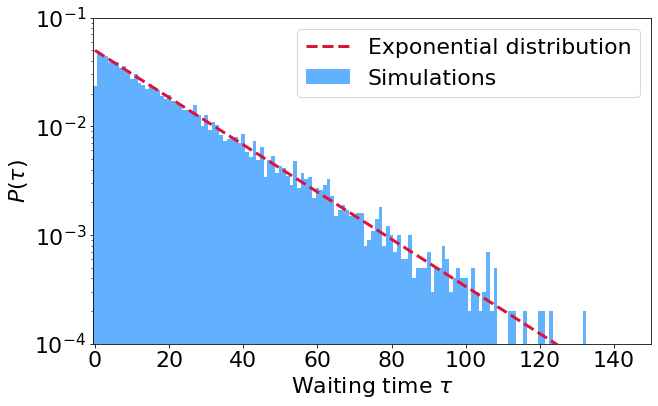

In [9]:
bin_edges = np.arange(np.max(waiting_times)+1)-0.5

hist, bin_edges = np.histogram(waiting_times, bins= bin_edges,density=True)
bin_centers = bin_edges[1:] + bin_edges[:-1]
bin_centers /= 2


fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(bin_centers,hist,width=1,
       color='dodgerblue',label='Simulations',
      alpha=0.7)
ax.plot(bin_centers,np.exp(-bin_centers*gI)*gI,
        lw=3,label='Exponential distribution',
       ls='--',color='crimson')
ax.set_ylim(1e-4,1e-1)
ax.set_xlim(-0.5,150)
ax.set_yscale('log')
ax.set_xlabel(r'Waiting time $\tau$')
ax.set_ylabel(r'$P(\tau)$')
ax.legend(loc='best')
plt.show(fig)
plt.close(fig)

### $k=100$:

In [10]:
k   = 100           # number of stages
gI   = 0.05            # recovery rate of asymptomatic infectives 

I0 = np.zeros(k,dtype=int)
I0[0] = 1                   
S0  = np.array([0])
Ni = np.array([1],dtype=float)

# instantiate model
parameters = {'alpha':0., 'beta':beta, 'gI':gI, 'k':k,'fsa':fsa}
model = pyross.stochastic.SIkR(parameters, M, Ni)

N_runs = 10000
waiting_times = np.zeros(N_runs,dtype=float)
for i in range(N_runs):
    data = model.simulate(S0, I0, contactMatrix, Tf, -1)
    waiting_times[i] = data['t'][-1]

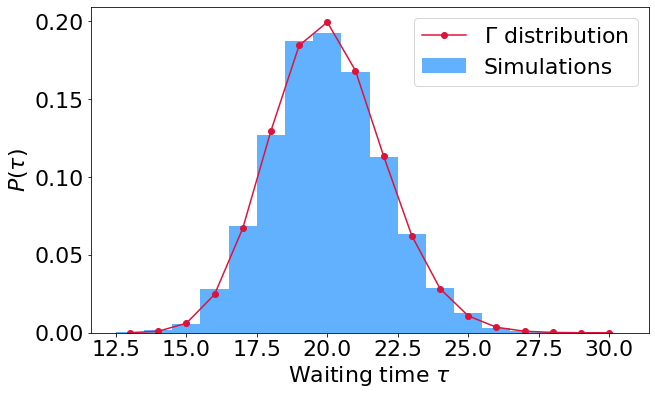

In [11]:
bin_edges = np.arange(np.floor(np.min(waiting_times)),np.ceil(np.max(waiting_times))+1)-0.5

hist, bin_edges = np.histogram(waiting_times, bins= bin_edges,density=True)
bin_centers = bin_edges[1:] + bin_edges[:-1]
bin_centers /= 2

import scipy.special
shape = k
scale = 1/(k*gI)
gamma_dist = bin_centers**(shape-1)*np.exp(-bin_centers/scale)/scale**shape/scipy.special.factorial(shape-1)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(bin_centers,hist,width=1,
       color='dodgerblue',label='Simulations',
      alpha=0.7)
ax.plot(bin_centers,gamma_dist,
        label=r'$\Gamma$ distribution',
        marker='o',color='crimson')
#ax.set_yscale('log')
ax.legend() #loc=8)
ax.set_xlabel(r'Waiting time $\tau$')
ax.set_ylabel(r'$P(\tau)$')
plt.show(fig)
plt.close(fig)